In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Kr2011_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2922, 6) (2922, 6)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)


def G2(data, pred):
    
    sbj_indices = tf.cast(data[:, 4], tf.int32)
    
    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    

    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2 + ll3, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 4], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 843ms/step - loss: 28705.8691
Epoch 2/5000
1/1 [==============================] - 0s 3ms/step - loss: 28487.1504
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 28333.2754
Epoch 4/5000
1/1 [==============================] - 0s 4ms/step - loss: 28207.0098
Epoch 5/5000
1/1 [==============================] - 0s 3ms/step - loss: 28096.7070
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 27996.9941
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 27904.8770
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 27818.4785
Epoch 9/5000
1/1 [==============================] - 0s 5ms/step - loss: 27736.5430
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 27658.2129
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 27582.8398
Epoch 12/5000
1/1 [==============================] - 0s 3ms/step - loss: 27509.9512

1/1 [==============================] - 0s 4ms/step - loss: 23275.9707
Epoch 99/5000
1/1 [==============================] - 0s 3ms/step - loss: 23238.3633
Epoch 100/5000
1/1 [==============================] - 0s 3ms/step - loss: 23200.9863
Epoch 101/5000
1/1 [==============================] - 0s 4ms/step - loss: 23163.8418
Epoch 102/5000
1/1 [==============================] - 0s 3ms/step - loss: 23126.9238
Epoch 103/5000
1/1 [==============================] - 0s 4ms/step - loss: 23090.2402
Epoch 104/5000
1/1 [==============================] - 0s 3ms/step - loss: 23053.7832
Epoch 105/5000
1/1 [==============================] - 0s 3ms/step - loss: 23017.5527
Epoch 106/5000
1/1 [==============================] - 0s 3ms/step - loss: 22981.5469
Epoch 107/5000
1/1 [==============================] - 0s 4ms/step - loss: 22945.7754
Epoch 108/5000
1/1 [==============================] - 0s 3ms/step - loss: 22910.2246
Epoch 109/5000
1/1 [==============================] - 0s 3ms/step - loss: 22874.8

1/1 [==============================] - 0s 3ms/step - loss: 20596.9727
Epoch 195/5000
1/1 [==============================] - 0s 3ms/step - loss: 20577.2031
Epoch 196/5000
1/1 [==============================] - 0s 3ms/step - loss: 20557.5664
Epoch 197/5000
1/1 [==============================] - 0s 3ms/step - loss: 20538.0547
Epoch 198/5000
1/1 [==============================] - 0s 4ms/step - loss: 20518.6641
Epoch 199/5000
1/1 [==============================] - 0s 3ms/step - loss: 20499.3945
Epoch 200/5000
1/1 [==============================] - 0s 3ms/step - loss: 20480.2461
Epoch 201/5000
1/1 [==============================] - 0s 3ms/step - loss: 20461.2188
Epoch 202/5000
1/1 [==============================] - 0s 4ms/step - loss: 20442.3086
Epoch 203/5000
1/1 [==============================] - 0s 3ms/step - loss: 20423.5176
Epoch 204/5000
1/1 [==============================] - 0s 3ms/step - loss: 20404.8418
Epoch 205/5000
1/1 [==============================] - 0s 3ms/step - loss: 20386.

1/1 [==============================] - 0s 3ms/step - loss: 19122.7051
Epoch 291/5000
1/1 [==============================] - 0s 3ms/step - loss: 19110.5293
Epoch 292/5000
1/1 [==============================] - 0s 3ms/step - loss: 19098.3984
Epoch 293/5000
1/1 [==============================] - 0s 4ms/step - loss: 19086.3086
Epoch 294/5000
1/1 [==============================] - 0s 3ms/step - loss: 19074.2637
Epoch 295/5000
1/1 [==============================] - 0s 3ms/step - loss: 19062.2598
Epoch 296/5000
1/1 [==============================] - 0s 3ms/step - loss: 19050.2949
Epoch 297/5000
1/1 [==============================] - 0s 4ms/step - loss: 19038.3789
Epoch 298/5000
1/1 [==============================] - 0s 3ms/step - loss: 19026.5020
Epoch 299/5000
1/1 [==============================] - 0s 3ms/step - loss: 19014.6680
Epoch 300/5000
1/1 [==============================] - 0s 3ms/step - loss: 19002.8730
Epoch 301/5000
1/1 [==============================] - 0s 3ms/step - loss: 18991.

1/1 [==============================] - 0s 4ms/step - loss: 18105.4004
Epoch 387/5000
1/1 [==============================] - 0s 4ms/step - loss: 18096.0195
Epoch 388/5000
1/1 [==============================] - 0s 3ms/step - loss: 18086.6582
Epoch 389/5000
1/1 [==============================] - 0s 3ms/step - loss: 18077.3164
Epoch 390/5000
1/1 [==============================] - 0s 2ms/step - loss: 18067.9922
Epoch 391/5000
1/1 [==============================] - 0s 4ms/step - loss: 18058.6855
Epoch 392/5000
1/1 [==============================] - 0s 3ms/step - loss: 18049.4023
Epoch 393/5000
1/1 [==============================] - 0s 3ms/step - loss: 18040.1328
Epoch 394/5000
1/1 [==============================] - 0s 3ms/step - loss: 18030.8809
Epoch 395/5000
1/1 [==============================] - 0s 4ms/step - loss: 18021.6543
Epoch 396/5000
1/1 [==============================] - 0s 3ms/step - loss: 18012.4414
Epoch 397/5000
1/1 [==============================] - 0s 3ms/step - loss: 18003.

1/1 [==============================] - 0s 3ms/step - loss: 17279.7559
Epoch 483/5000
1/1 [==============================] - 0s 3ms/step - loss: 17271.8535
Epoch 484/5000
1/1 [==============================] - 0s 4ms/step - loss: 17263.9668
Epoch 485/5000
1/1 [==============================] - 0s 4ms/step - loss: 17256.0898
Epoch 486/5000
1/1 [==============================] - 0s 3ms/step - loss: 17248.2285
Epoch 487/5000
1/1 [==============================] - 0s 3ms/step - loss: 17240.3789
Epoch 488/5000
1/1 [==============================] - 0s 3ms/step - loss: 17232.5469
Epoch 489/5000
1/1 [==============================] - 0s 3ms/step - loss: 17224.7227
Epoch 490/5000
1/1 [==============================] - 0s 3ms/step - loss: 17216.9121
Epoch 491/5000
1/1 [==============================] - 0s 4ms/step - loss: 17209.1172
Epoch 492/5000
1/1 [==============================] - 0s 8ms/step - loss: 17201.3320
Epoch 493/5000
1/1 [==============================] - 0s 3ms/step - loss: 17193.

1/1 [==============================] - 0s 3ms/step - loss: 16577.9453
Epoch 579/5000
1/1 [==============================] - 0s 3ms/step - loss: 16571.2188
Epoch 580/5000
1/1 [==============================] - 0s 3ms/step - loss: 16564.5000
Epoch 581/5000
1/1 [==============================] - 0s 3ms/step - loss: 16557.7949
Epoch 582/5000
1/1 [==============================] - 0s 3ms/step - loss: 16551.1016
Epoch 583/5000
1/1 [==============================] - 0s 4ms/step - loss: 16544.4219
Epoch 584/5000
1/1 [==============================] - 0s 4ms/step - loss: 16537.7520
Epoch 585/5000
1/1 [==============================] - 0s 3ms/step - loss: 16531.0957
Epoch 586/5000
1/1 [==============================] - 0s 3ms/step - loss: 16524.4453
Epoch 587/5000
1/1 [==============================] - 0s 3ms/step - loss: 16517.8105
Epoch 588/5000
1/1 [==============================] - 0s 4ms/step - loss: 16511.1934
Epoch 589/5000
1/1 [==============================] - 0s 3ms/step - loss: 16504.

1/1 [==============================] - 0s 3ms/step - loss: 15984.4883
Epoch 675/5000
1/1 [==============================] - 0s 3ms/step - loss: 15978.8516
Epoch 676/5000
1/1 [==============================] - 0s 3ms/step - loss: 15973.2266
Epoch 677/5000
1/1 [==============================] - 0s 3ms/step - loss: 15967.6094
Epoch 678/5000
1/1 [==============================] - 0s 3ms/step - loss: 15962.0059
Epoch 679/5000
1/1 [==============================] - 0s 3ms/step - loss: 15956.4131
Epoch 680/5000
1/1 [==============================] - 0s 3ms/step - loss: 15950.8291
Epoch 681/5000
1/1 [==============================] - 0s 3ms/step - loss: 15945.2607
Epoch 682/5000
1/1 [==============================] - 0s 3ms/step - loss: 15939.7012
Epoch 683/5000
1/1 [==============================] - 0s 3ms/step - loss: 15934.1523
Epoch 684/5000
1/1 [==============================] - 0s 4ms/step - loss: 15928.6133
Epoch 685/5000
1/1 [==============================] - 0s 3ms/step - loss: 15923.

1/1 [==============================] - 0s 4ms/step - loss: 15492.7725
Epoch 771/5000
1/1 [==============================] - 0s 4ms/step - loss: 15488.1504
Epoch 772/5000
1/1 [==============================] - 0s 4ms/step - loss: 15483.5410
Epoch 773/5000
1/1 [==============================] - 0s 3ms/step - loss: 15478.9414
Epoch 774/5000
1/1 [==============================] - 0s 4ms/step - loss: 15474.3516
Epoch 775/5000
1/1 [==============================] - 0s 4ms/step - loss: 15469.7715
Epoch 776/5000
1/1 [==============================] - 0s 4ms/step - loss: 15465.2002
Epoch 777/5000
1/1 [==============================] - 0s 4ms/step - loss: 15460.6416
Epoch 778/5000
1/1 [==============================] - 0s 4ms/step - loss: 15456.0908
Epoch 779/5000
1/1 [==============================] - 0s 4ms/step - loss: 15451.5508
Epoch 780/5000
1/1 [==============================] - 0s 4ms/step - loss: 15447.0195
Epoch 781/5000
1/1 [==============================] - 0s 4ms/step - loss: 15442.

1/1 [==============================] - 0s 4ms/step - loss: 15092.5986
Epoch 867/5000
1/1 [==============================] - 0s 3ms/step - loss: 15088.8682
Epoch 868/5000
1/1 [==============================] - 0s 3ms/step - loss: 15085.1475
Epoch 869/5000
1/1 [==============================] - 0s 4ms/step - loss: 15081.4355
Epoch 870/5000
1/1 [==============================] - 0s 3ms/step - loss: 15077.7285
Epoch 871/5000
1/1 [==============================] - 0s 4ms/step - loss: 15074.0371
Epoch 872/5000
1/1 [==============================] - 0s 3ms/step - loss: 15070.3506
Epoch 873/5000
1/1 [==============================] - 0s 3ms/step - loss: 15066.6719
Epoch 874/5000
1/1 [==============================] - 0s 3ms/step - loss: 15063.0010
Epoch 875/5000
1/1 [==============================] - 0s 3ms/step - loss: 15059.3389
Epoch 876/5000
1/1 [==============================] - 0s 3ms/step - loss: 15055.6875
Epoch 877/5000
1/1 [==============================] - 0s 4ms/step - loss: 15052.

1/1 [==============================] - 0s 3ms/step - loss: 14769.4707
Epoch 963/5000
1/1 [==============================] - 0s 3ms/step - loss: 14766.4248
Epoch 964/5000
1/1 [==============================] - 0s 4ms/step - loss: 14763.3809
Epoch 965/5000
1/1 [==============================] - 0s 4ms/step - loss: 14760.3477
Epoch 966/5000
1/1 [==============================] - 0s 4ms/step - loss: 14757.3174
Epoch 967/5000
1/1 [==============================] - 0s 3ms/step - loss: 14754.2939
Epoch 968/5000
1/1 [==============================] - 0s 4ms/step - loss: 14751.2715
Epoch 969/5000
1/1 [==============================] - 0s 3ms/step - loss: 14748.2578
Epoch 970/5000
1/1 [==============================] - 0s 4ms/step - loss: 14745.2461
Epoch 971/5000
1/1 [==============================] - 0s 3ms/step - loss: 14742.2412
Epoch 972/5000
1/1 [==============================] - 0s 4ms/step - loss: 14739.2412
Epoch 973/5000
1/1 [==============================] - 0s 4ms/step - loss: 14736.

1/1 [==============================] - 0s 4ms/step - loss: 14494.9443
Epoch 1058/5000
1/1 [==============================] - 0s 3ms/step - loss: 14492.0879
Epoch 1059/5000
1/1 [==============================] - 0s 4ms/step - loss: 14489.2324
Epoch 1060/5000
1/1 [==============================] - 0s 4ms/step - loss: 14486.3691
Epoch 1061/5000
1/1 [==============================] - 0s 3ms/step - loss: 14483.5068
Epoch 1062/5000
1/1 [==============================] - 0s 4ms/step - loss: 14480.6416
Epoch 1063/5000
1/1 [==============================] - 0s 3ms/step - loss: 14477.7715
Epoch 1064/5000
1/1 [==============================] - 0s 3ms/step - loss: 14474.9004
Epoch 1065/5000
1/1 [==============================] - 0s 4ms/step - loss: 14472.0264
Epoch 1066/5000
1/1 [==============================] - 0s 4ms/step - loss: 14469.1475
Epoch 1067/5000
1/1 [==============================] - 0s 4ms/step - loss: 14466.2646
Epoch 1068/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 14204.5547
Epoch 1153/5000
1/1 [==============================] - 0s 3ms/step - loss: 14201.3027
Epoch 1154/5000
1/1 [==============================] - 0s 3ms/step - loss: 14198.0518
Epoch 1155/5000
1/1 [==============================] - 0s 4ms/step - loss: 14194.7969
Epoch 1156/5000
1/1 [==============================] - 0s 3ms/step - loss: 14191.5410
Epoch 1157/5000
1/1 [==============================] - 0s 4ms/step - loss: 14188.2852
Epoch 1158/5000
1/1 [==============================] - 0s 3ms/step - loss: 14185.0264
Epoch 1159/5000
1/1 [==============================] - 0s 3ms/step - loss: 14181.7686
Epoch 1160/5000
1/1 [==============================] - 0s 4ms/step - loss: 14178.5088
Epoch 1161/5000
1/1 [==============================] - 0s 4ms/step - loss: 14175.2510
Epoch 1162/5000
1/1 [==============================] - 0s 3ms/step - loss: 14171.9932
Epoch 1163/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 13906.1865
Epoch 1248/5000
1/1 [==============================] - 0s 4ms/step - loss: 13903.2529
Epoch 1249/5000
1/1 [==============================] - 0s 3ms/step - loss: 13900.3203
Epoch 1250/5000
1/1 [==============================] - 0s 3ms/step - loss: 13897.3965
Epoch 1251/5000
1/1 [==============================] - 0s 3ms/step - loss: 13894.4746
Epoch 1252/5000
1/1 [==============================] - 0s 3ms/step - loss: 13891.5576
Epoch 1253/5000
1/1 [==============================] - 0s 4ms/step - loss: 13888.6465
Epoch 1254/5000
1/1 [==============================] - 0s 3ms/step - loss: 13885.7402
Epoch 1255/5000
1/1 [==============================] - 0s 3ms/step - loss: 13882.8389
Epoch 1256/5000
1/1 [==============================] - 0s 3ms/step - loss: 13879.9395
Epoch 1257/5000
1/1 [==============================] - 0s 5ms/step - loss: 13877.0498
Epoch 1258/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 13651.7129
Epoch 1343/5000
1/1 [==============================] - 0s 3ms/step - loss: 13649.2236
Epoch 1344/5000
1/1 [==============================] - 0s 3ms/step - loss: 13646.7324
Epoch 1345/5000
1/1 [==============================] - 0s 3ms/step - loss: 13644.2422
Epoch 1346/5000
1/1 [==============================] - 0s 10ms/step - loss: 13641.7539
Epoch 1347/5000
1/1 [==============================] - 0s 3ms/step - loss: 13639.2637
Epoch 1348/5000
1/1 [==============================] - 0s 4ms/step - loss: 13636.7764
Epoch 1349/5000
1/1 [==============================] - 0s 4ms/step - loss: 13634.2861
Epoch 1350/5000
1/1 [==============================] - 0s 3ms/step - loss: 13631.7988
Epoch 1351/5000
1/1 [==============================] - 0s 4ms/step - loss: 13629.3086
Epoch 1352/5000
1/1 [==============================] - 0s 4ms/step - loss: 13626.8203
Epoch 1353/5000
1/1 [==============================] - 0s 4ms/step - 

1/1 [==============================] - 0s 4ms/step - loss: 13401.1182
Epoch 1438/5000
1/1 [==============================] - 0s 3ms/step - loss: 13398.0508
Epoch 1439/5000
1/1 [==============================] - 0s 4ms/step - loss: 13394.9668
Epoch 1440/5000
1/1 [==============================] - 0s 4ms/step - loss: 13391.8643
Epoch 1441/5000
1/1 [==============================] - 0s 4ms/step - loss: 13388.7451
Epoch 1442/5000
1/1 [==============================] - 0s 3ms/step - loss: 13385.6055
Epoch 1443/5000
1/1 [==============================] - 0s 3ms/step - loss: 13382.4502
Epoch 1444/5000
1/1 [==============================] - 0s 4ms/step - loss: 13379.2754
Epoch 1445/5000
1/1 [==============================] - 0s 3ms/step - loss: 13376.0859
Epoch 1446/5000
1/1 [==============================] - 0s 3ms/step - loss: 13372.8730
Epoch 1447/5000
1/1 [==============================] - 0s 3ms/step - loss: 13369.6445
Epoch 1448/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 13000.2930
Epoch 1533/5000
1/1 [==============================] - 0s 3ms/step - loss: 12994.7471
Epoch 1534/5000
1/1 [==============================] - 0s 4ms/step - loss: 12989.1729
Epoch 1535/5000
1/1 [==============================] - 0s 3ms/step - loss: 12983.5742
Epoch 1536/5000
1/1 [==============================] - 0s 4ms/step - loss: 12977.9512
Epoch 1537/5000
1/1 [==============================] - 0s 3ms/step - loss: 12972.3057
Epoch 1538/5000
1/1 [==============================] - 0s 3ms/step - loss: 12966.6328
Epoch 1539/5000
1/1 [==============================] - 0s 3ms/step - loss: 12960.9365
Epoch 1540/5000
1/1 [==============================] - 0s 4ms/step - loss: 12955.2139
Epoch 1541/5000
1/1 [==============================] - 0s 3ms/step - loss: 12949.4727
Epoch 1542/5000
1/1 [==============================] - 0s 4ms/step - loss: 12943.7061
Epoch 1543/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 12410.4180
Epoch 1628/5000
1/1 [==============================] - 0s 3ms/step - loss: 12404.1807
Epoch 1629/5000
1/1 [==============================] - 0s 3ms/step - loss: 12397.9561
Epoch 1630/5000
1/1 [==============================] - 0s 4ms/step - loss: 12391.7441
Epoch 1631/5000
1/1 [==============================] - 0s 5ms/step - loss: 12385.5479
Epoch 1632/5000
1/1 [==============================] - 0s 4ms/step - loss: 12379.3672
Epoch 1633/5000
1/1 [==============================] - 0s 3ms/step - loss: 12373.2031
Epoch 1634/5000
1/1 [==============================] - 0s 3ms/step - loss: 12367.0557
Epoch 1635/5000
1/1 [==============================] - 0s 4ms/step - loss: 12360.9189
Epoch 1636/5000
1/1 [==============================] - 0s 3ms/step - loss: 12354.8037
Epoch 1637/5000
1/1 [==============================] - 0s 4ms/step - loss: 12348.7051
Epoch 1638/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 11904.7607
Epoch 1723/5000
1/1 [==============================] - 0s 4ms/step - loss: 11900.3369
Epoch 1724/5000
1/1 [==============================] - 0s 4ms/step - loss: 11895.9238
Epoch 1725/5000
1/1 [==============================] - 0s 4ms/step - loss: 11891.5225
Epoch 1726/5000
1/1 [==============================] - 0s 4ms/step - loss: 11887.1338
Epoch 1727/5000
1/1 [==============================] - 0s 4ms/step - loss: 11882.7539
Epoch 1728/5000
1/1 [==============================] - 0s 4ms/step - loss: 11878.3857
Epoch 1729/5000
1/1 [==============================] - 0s 4ms/step - loss: 11874.0273
Epoch 1730/5000
1/1 [==============================] - 0s 4ms/step - loss: 11869.6807
Epoch 1731/5000
1/1 [==============================] - 0s 5ms/step - loss: 11865.3447
Epoch 1732/5000
1/1 [==============================] - 0s 4ms/step - loss: 11861.0176
Epoch 1733/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 11511.8945
Epoch 1818/5000
1/1 [==============================] - 0s 3ms/step - loss: 11507.8457
Epoch 1819/5000
1/1 [==============================] - 0s 5ms/step - loss: 11503.7891
Epoch 1820/5000
1/1 [==============================] - 0s 5ms/step - loss: 11499.7402
Epoch 1821/5000
1/1 [==============================] - 0s 3ms/step - loss: 11495.6738
Epoch 1822/5000
1/1 [==============================] - 0s 4ms/step - loss: 11491.6260
Epoch 1823/5000
1/1 [==============================] - 0s 4ms/step - loss: 11487.5674
Epoch 1824/5000
1/1 [==============================] - 0s 4ms/step - loss: 11483.5117
Epoch 1825/5000
1/1 [==============================] - 0s 3ms/step - loss: 11479.4492
Epoch 1826/5000
1/1 [==============================] - 0s 5ms/step - loss: 11475.3965
Epoch 1827/5000
1/1 [==============================] - 0s 4ms/step - loss: 11471.3340
Epoch 1828/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 11126.5244
Epoch 1913/5000
1/1 [==============================] - 0s 3ms/step - loss: 11122.4873
Epoch 1914/5000
1/1 [==============================] - 0s 3ms/step - loss: 11118.4326
Epoch 1915/5000
1/1 [==============================] - 0s 4ms/step - loss: 11114.3721
Epoch 1916/5000
1/1 [==============================] - 0s 3ms/step - loss: 11110.3438
Epoch 1917/5000
1/1 [==============================] - 0s 3ms/step - loss: 11106.2920
Epoch 1918/5000
1/1 [==============================] - 0s 3ms/step - loss: 11102.2617
Epoch 1919/5000
1/1 [==============================] - 0s 4ms/step - loss: 11098.2246
Epoch 1920/5000
1/1 [==============================] - 0s 3ms/step - loss: 11094.1914
Epoch 1921/5000
1/1 [==============================] - 0s 3ms/step - loss: 11090.1387
Epoch 1922/5000
1/1 [==============================] - 0s 3ms/step - loss: 11086.1299
Epoch 1923/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10749.7314
Epoch 2008/5000
1/1 [==============================] - 0s 4ms/step - loss: 10745.8584
Epoch 2009/5000
1/1 [==============================] - 0s 3ms/step - loss: 10742.0107
Epoch 2010/5000
1/1 [==============================] - 0s 3ms/step - loss: 10738.1553
Epoch 2011/5000
1/1 [==============================] - 0s 3ms/step - loss: 10734.3076
Epoch 2012/5000
1/1 [==============================] - 0s 3ms/step - loss: 10730.4961
Epoch 2013/5000
1/1 [==============================] - 0s 3ms/step - loss: 10726.6240
Epoch 2014/5000
1/1 [==============================] - 0s 3ms/step - loss: 10722.7803
Epoch 2015/5000
1/1 [==============================] - 0s 3ms/step - loss: 10718.9307
Epoch 2016/5000
1/1 [==============================] - 0s 3ms/step - loss: 10715.1182
Epoch 2017/5000
1/1 [==============================] - 0s 3ms/step - loss: 10711.2939
Epoch 2018/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10404.2881
Epoch 2103/5000
1/1 [==============================] - 0s 3ms/step - loss: 10400.9668
Epoch 2104/5000
1/1 [==============================] - 0s 3ms/step - loss: 10397.6650
Epoch 2105/5000
1/1 [==============================] - 0s 3ms/step - loss: 10394.4668
Epoch 2106/5000
1/1 [==============================] - 0s 3ms/step - loss: 10391.1904
Epoch 2107/5000
1/1 [==============================] - 0s 3ms/step - loss: 10388.0283
Epoch 2108/5000
1/1 [==============================] - 0s 3ms/step - loss: 10384.7578
Epoch 2109/5000
1/1 [==============================] - 0s 4ms/step - loss: 10381.4531
Epoch 2110/5000
1/1 [==============================] - 0s 3ms/step - loss: 10378.3057
Epoch 2111/5000
1/1 [==============================] - 0s 3ms/step - loss: 10375.1680
Epoch 2112/5000
1/1 [==============================] - 0s 3ms/step - loss: 10371.8486
Epoch 2113/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10134.6602
Epoch 2198/5000
1/1 [==============================] - 0s 3ms/step - loss: 10132.2178
Epoch 2199/5000
1/1 [==============================] - 0s 3ms/step - loss: 10129.6533
Epoch 2200/5000
1/1 [==============================] - 0s 3ms/step - loss: 10127.2061
Epoch 2201/5000
1/1 [==============================] - 0s 4ms/step - loss: 10124.6963
Epoch 2202/5000
1/1 [==============================] - 0s 3ms/step - loss: 10122.2510
Epoch 2203/5000
1/1 [==============================] - 0s 3ms/step - loss: 10119.6475
Epoch 2204/5000
1/1 [==============================] - 0s 3ms/step - loss: 10117.3623
Epoch 2205/5000
1/1 [==============================] - 0s 4ms/step - loss: 10115.2354
Epoch 2206/5000
1/1 [==============================] - 0s 3ms/step - loss: 10112.7490
Epoch 2207/5000
1/1 [==============================] - 0s 3ms/step - loss: 10110.3252
Epoch 2208/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 9921.5225
Epoch 2293/5000
1/1 [==============================] - 0s 3ms/step - loss: 9919.5830
Epoch 2294/5000
1/1 [==============================] - 0s 3ms/step - loss: 9917.3008
Epoch 2295/5000
1/1 [==============================] - 0s 4ms/step - loss: 9915.2646
Epoch 2296/5000
1/1 [==============================] - 0s 3ms/step - loss: 9913.3838
Epoch 2297/5000
1/1 [==============================] - 0s 3ms/step - loss: 9911.3867
Epoch 2298/5000
1/1 [==============================] - 0s 4ms/step - loss: 9909.0684
Epoch 2299/5000
1/1 [==============================] - 0s 3ms/step - loss: 9907.2998
Epoch 2300/5000
1/1 [==============================] - 0s 4ms/step - loss: 9905.2588
Epoch 2301/5000
1/1 [==============================] - 0s 3ms/step - loss: 9903.4736
Epoch 2302/5000
1/1 [==============================] - 0s 3ms/step - loss: 9901.1553
Epoch 2303/5000
1/1 [==============================] - 0s 4ms/step - loss: 9898.8

1/1 [==============================] - 0s 3ms/step - loss: 9736.5166
Epoch 2389/5000
1/1 [==============================] - 0s 3ms/step - loss: 9733.9912
Epoch 2390/5000
1/1 [==============================] - 0s 3ms/step - loss: 9732.9502
Epoch 2391/5000
1/1 [==============================] - 0s 3ms/step - loss: 9730.8916
Epoch 2392/5000
1/1 [==============================] - 0s 3ms/step - loss: 9728.5459
Epoch 2393/5000
1/1 [==============================] - 0s 3ms/step - loss: 9726.8711
Epoch 2394/5000
1/1 [==============================] - 0s 3ms/step - loss: 9725.7139
Epoch 2395/5000
1/1 [==============================] - 0s 3ms/step - loss: 9723.4785
Epoch 2396/5000
1/1 [==============================] - 0s 3ms/step - loss: 9722.3486
Epoch 2397/5000
1/1 [==============================] - 0s 3ms/step - loss: 9720.1895
Epoch 2398/5000
1/1 [==============================] - 0s 4ms/step - loss: 9719.3633
Epoch 2399/5000
1/1 [==============================] - 0s 3ms/step - loss: 9718.1

1/1 [==============================] - 0s 4ms/step - loss: 9600.9658
Epoch 2485/5000
1/1 [==============================] - 0s 4ms/step - loss: 9600.0264
Epoch 2486/5000
1/1 [==============================] - 0s 3ms/step - loss: 9599.1455
Epoch 2487/5000
1/1 [==============================] - 0s 3ms/step - loss: 9598.3389
Epoch 2488/5000
1/1 [==============================] - 0s 3ms/step - loss: 9597.7490
Epoch 2489/5000
1/1 [==============================] - 0s 3ms/step - loss: 9596.3877
Epoch 2490/5000
1/1 [==============================] - 0s 3ms/step - loss: 9595.2412
Epoch 2491/5000
1/1 [==============================] - 0s 4ms/step - loss: 9594.0596
Epoch 2492/5000
1/1 [==============================] - 0s 3ms/step - loss: 9592.6436
Epoch 2493/5000
1/1 [==============================] - 0s 4ms/step - loss: 9591.8389
Epoch 2494/5000
1/1 [==============================] - 0s 3ms/step - loss: 9590.0479
Epoch 2495/5000
1/1 [==============================] - 0s 3ms/step - loss: 9589.4

1/1 [==============================] - 0s 3ms/step - loss: 9520.3604
Epoch 2581/5000
1/1 [==============================] - 0s 3ms/step - loss: 9519.6152
Epoch 2582/5000
1/1 [==============================] - 0s 4ms/step - loss: 9518.9131
Epoch 2583/5000
1/1 [==============================] - 0s 3ms/step - loss: 9518.5830
Epoch 2584/5000
1/1 [==============================] - 0s 3ms/step - loss: 9518.1729
Epoch 2585/5000
1/1 [==============================] - 0s 3ms/step - loss: 9517.7168
Epoch 2586/5000
1/1 [==============================] - 0s 4ms/step - loss: 9517.7432
Epoch 2587/5000
1/1 [==============================] - 0s 3ms/step - loss: 9518.7773
Epoch 2588/5000
1/1 [==============================] - 0s 4ms/step - loss: 9518.5576
Epoch 2589/5000
1/1 [==============================] - 0s 3ms/step - loss: 9517.7812
Epoch 2590/5000
1/1 [==============================] - 0s 3ms/step - loss: 9516.2627
Epoch 2591/5000
1/1 [==============================] - 0s 3ms/step - loss: 9513.9

1/1 [==============================] - 0s 3ms/step - loss: 9472.7168
Epoch 2677/5000
1/1 [==============================] - 0s 3ms/step - loss: 9472.8906
Epoch 2678/5000
1/1 [==============================] - 0s 3ms/step - loss: 9469.1475
Epoch 2679/5000
1/1 [==============================] - 0s 3ms/step - loss: 9465.6650
Epoch 2680/5000
1/1 [==============================] - 0s 3ms/step - loss: 9464.1904
Epoch 2681/5000
1/1 [==============================] - 0s 3ms/step - loss: 9463.7256
Epoch 2682/5000
1/1 [==============================] - 0s 3ms/step - loss: 9463.5068
Epoch 2683/5000
1/1 [==============================] - 0s 3ms/step - loss: 9462.4424
Epoch 2684/5000
1/1 [==============================] - 0s 3ms/step - loss: 9461.4316
Epoch 2685/5000
1/1 [==============================] - 0s 3ms/step - loss: 9462.1533
Epoch 2686/5000
1/1 [==============================] - 0s 4ms/step - loss: 9462.3076
Epoch 2687/5000
1/1 [==============================] - 0s 3ms/step - loss: 9461.1

1/1 [==============================] - 0s 3ms/step - loss: 9426.5547
Epoch 2773/5000
1/1 [==============================] - 0s 4ms/step - loss: 9425.9873
Epoch 2774/5000
1/1 [==============================] - 0s 4ms/step - loss: 9427.2393
Epoch 2775/5000
1/1 [==============================] - 0s 3ms/step - loss: 9429.8086
Epoch 2776/5000
1/1 [==============================] - 0s 3ms/step - loss: 9432.1855
Epoch 2777/5000
1/1 [==============================] - 0s 3ms/step - loss: 9426.5039
Epoch 2778/5000
1/1 [==============================] - 0s 3ms/step - loss: 9424.2402
Epoch 2779/5000
1/1 [==============================] - 0s 3ms/step - loss: 9423.7861
Epoch 2780/5000
1/1 [==============================] - 0s 4ms/step - loss: 9421.0264
Epoch 2781/5000
1/1 [==============================] - 0s 3ms/step - loss: 9421.8975
Epoch 2782/5000
1/1 [==============================] - 0s 3ms/step - loss: 9420.2090
Epoch 2783/5000
1/1 [==============================] - 0s 3ms/step - loss: 9419.2

1/1 [==============================] - 0s 3ms/step - loss: 9389.8398
Epoch 2869/5000
1/1 [==============================] - 0s 3ms/step - loss: 9389.4814
Epoch 2870/5000
1/1 [==============================] - 0s 3ms/step - loss: 9390.7695
Epoch 2871/5000
1/1 [==============================] - 0s 4ms/step - loss: 9393.9199
Epoch 2872/5000
1/1 [==============================] - 0s 3ms/step - loss: 9392.7939
Epoch 2873/5000
1/1 [==============================] - 0s 3ms/step - loss: 9396.0605
Epoch 2874/5000
1/1 [==============================] - 0s 3ms/step - loss: 9393.5576
Epoch 2875/5000
1/1 [==============================] - 0s 4ms/step - loss: 9391.1826
Epoch 2876/5000
1/1 [==============================] - 0s 3ms/step - loss: 9387.7852
Epoch 2877/5000
1/1 [==============================] - 0s 3ms/step - loss: 9387.2354
Epoch 2878/5000
1/1 [==============================] - 0s 3ms/step - loss: 9385.8809
Epoch 2879/5000
1/1 [==============================] - 0s 3ms/step - loss: 9386.5

1/1 [==============================] - 0s 4ms/step - loss: 9360.2812
Epoch 2965/5000
1/1 [==============================] - 0s 3ms/step - loss: 9360.9941
Epoch 2966/5000
1/1 [==============================] - 0s 3ms/step - loss: 9362.1787
Epoch 2967/5000
1/1 [==============================] - 0s 3ms/step - loss: 9413.5244
Epoch 2968/5000
1/1 [==============================] - 0s 3ms/step - loss: 9362.8281
Epoch 2969/5000
1/1 [==============================] - 0s 3ms/step - loss: 9363.0439
Epoch 2970/5000
1/1 [==============================] - 0s 3ms/step - loss: 9362.8525
Epoch 2971/5000
1/1 [==============================] - 0s 3ms/step - loss: 9361.3916
Epoch 2972/5000
1/1 [==============================] - 0s 4ms/step - loss: 9365.2725
Epoch 2973/5000
1/1 [==============================] - 0s 4ms/step - loss: 9369.9062
Epoch 2974/5000
1/1 [==============================] - 0s 3ms/step - loss: 9362.2139
Epoch 2975/5000
1/1 [==============================] - 0s 3ms/step - loss: 9358.9

1/1 [==============================] - 0s 3ms/step - loss: 9337.2588
Epoch 3061/5000
1/1 [==============================] - 0s 3ms/step - loss: 9335.6621
Epoch 3062/5000
1/1 [==============================] - 0s 4ms/step - loss: 9338.7500
Epoch 3063/5000
1/1 [==============================] - 0s 3ms/step - loss: 9353.7393
Epoch 3064/5000
1/1 [==============================] - 0s 3ms/step - loss: 9336.7354
Epoch 3065/5000
1/1 [==============================] - 0s 3ms/step - loss: 9333.5332
Epoch 3066/5000
1/1 [==============================] - 0s 4ms/step - loss: 9333.0439
Epoch 3067/5000
1/1 [==============================] - 0s 3ms/step - loss: 9335.6006
Epoch 3068/5000
1/1 [==============================] - 0s 3ms/step - loss: 9334.6016
Epoch 3069/5000
1/1 [==============================] - 0s 4ms/step - loss: 9332.5547
Epoch 3070/5000
1/1 [==============================] - 0s 4ms/step - loss: 9333.5098
Epoch 3071/5000
1/1 [==============================] - 0s 3ms/step - loss: 9335.6

1/1 [==============================] - 0s 4ms/step - loss: 9311.2266
Epoch 3157/5000
1/1 [==============================] - 0s 3ms/step - loss: 9313.6729
Epoch 3158/5000
1/1 [==============================] - 0s 3ms/step - loss: 9315.5996
Epoch 3159/5000
1/1 [==============================] - 0s 3ms/step - loss: 9315.9854
Epoch 3160/5000
1/1 [==============================] - 0s 4ms/step - loss: 9315.3242
Epoch 3161/5000
1/1 [==============================] - 0s 3ms/step - loss: 9311.9736
Epoch 3162/5000
1/1 [==============================] - 0s 4ms/step - loss: 9310.3184
Epoch 3163/5000
1/1 [==============================] - 0s 3ms/step - loss: 9312.3877
Epoch 3164/5000
1/1 [==============================] - 0s 4ms/step - loss: 9313.1797
Epoch 3165/5000
1/1 [==============================] - 0s 3ms/step - loss: 9313.4258
Epoch 3166/5000
1/1 [==============================] - 0s 3ms/step - loss: 9313.8652
Epoch 3167/5000
1/1 [==============================] - 0s 3ms/step - loss: 9363.3

1/1 [==============================] - 0s 3ms/step - loss: 9292.0293
Epoch 3253/5000
1/1 [==============================] - 0s 4ms/step - loss: 9293.7979
Epoch 3254/5000
1/1 [==============================] - 0s 3ms/step - loss: 9295.6445
Epoch 3255/5000
1/1 [==============================] - 0s 3ms/step - loss: 9294.4287
Epoch 3256/5000
1/1 [==============================] - 0s 3ms/step - loss: 9296.2500
Epoch 3257/5000
1/1 [==============================] - 0s 4ms/step - loss: 9297.5840
Epoch 3258/5000
1/1 [==============================] - 0s 3ms/step - loss: 9347.4814
Epoch 3259/5000
1/1 [==============================] - 0s 3ms/step - loss: 9291.3359
Epoch 3260/5000
1/1 [==============================] - 0s 3ms/step - loss: 9287.8555
Epoch 3261/5000
1/1 [==============================] - 0s 3ms/step - loss: 9288.8340
Epoch 3262/5000
1/1 [==============================] - 0s 3ms/step - loss: 9288.6338
Epoch 3263/5000
1/1 [==============================] - 0s 3ms/step - loss: 9288.7

1/1 [==============================] - 0s 3ms/step - loss: 9274.0244
Epoch 3349/5000
1/1 [==============================] - 0s 4ms/step - loss: 9275.4736
Epoch 3350/5000
1/1 [==============================] - 0s 3ms/step - loss: 9272.7764
Epoch 3351/5000
1/1 [==============================] - 0s 3ms/step - loss: 9273.5996
Epoch 3352/5000
1/1 [==============================] - 0s 3ms/step - loss: 9273.1611
Epoch 3353/5000
1/1 [==============================] - 0s 3ms/step - loss: 9270.4883
Epoch 3354/5000
1/1 [==============================] - 0s 4ms/step - loss: 9272.0518
Epoch 3355/5000
1/1 [==============================] - 0s 3ms/step - loss: 9277.3193
Epoch 3356/5000
1/1 [==============================] - 0s 3ms/step - loss: 9282.2480
Epoch 3357/5000
1/1 [==============================] - 0s 3ms/step - loss: 9274.5186
Epoch 3358/5000
1/1 [==============================] - 0s 4ms/step - loss: 9270.1885
Epoch 3359/5000
1/1 [==============================] - 0s 3ms/step - loss: 9270.1

1/1 [==============================] - 0s 3ms/step - loss: 9258.7764
Epoch 3445/5000
1/1 [==============================] - 0s 3ms/step - loss: 9256.1670
Epoch 3446/5000
1/1 [==============================] - 0s 2ms/step - loss: 9254.7412
Epoch 3447/5000
1/1 [==============================] - 0s 3ms/step - loss: 9259.5723
Epoch 3448/5000
1/1 [==============================] - 0s 3ms/step - loss: 9257.5234
Epoch 3449/5000
1/1 [==============================] - 0s 3ms/step - loss: 9267.6963
Epoch 3450/5000
1/1 [==============================] - 0s 3ms/step - loss: 9289.8115
Epoch 3451/5000
1/1 [==============================] - 0s 3ms/step - loss: 9255.3408
Epoch 3452/5000
1/1 [==============================] - 0s 4ms/step - loss: 9253.9600
Epoch 3453/5000
1/1 [==============================] - 0s 3ms/step - loss: 9254.0664
Epoch 3454/5000
1/1 [==============================] - 0s 4ms/step - loss: 9253.1240
Epoch 3455/5000
1/1 [==============================] - 0s 3ms/step - loss: 9255.0

1/1 [==============================] - 0s 3ms/step - loss: 9286.7363
Epoch 3541/5000
1/1 [==============================] - 0s 3ms/step - loss: 9240.9766
Epoch 3542/5000
1/1 [==============================] - 0s 3ms/step - loss: 9242.0781
Epoch 3543/5000
1/1 [==============================] - 0s 3ms/step - loss: 9243.3789
Epoch 3544/5000
1/1 [==============================] - 0s 3ms/step - loss: 9243.9990
Epoch 3545/5000
1/1 [==============================] - 0s 3ms/step - loss: 9243.1426
Epoch 3546/5000
1/1 [==============================] - 0s 3ms/step - loss: 9241.6787
Epoch 3547/5000
1/1 [==============================] - 0s 3ms/step - loss: 9241.1406
Epoch 3548/5000
1/1 [==============================] - 0s 4ms/step - loss: 9243.6484
Epoch 3549/5000
1/1 [==============================] - 0s 3ms/step - loss: 9242.5098
Epoch 3550/5000
1/1 [==============================] - 0s 4ms/step - loss: 9238.9873
Epoch 3551/5000
1/1 [==============================] - 0s 3ms/step - loss: 9240.8

1/1 [==============================] - 0s 3ms/step - loss: 9233.0986
Epoch 3637/5000
1/1 [==============================] - 0s 4ms/step - loss: 9238.3154
Epoch 3638/5000
1/1 [==============================] - 0s 3ms/step - loss: 9227.3330
Epoch 3639/5000
1/1 [==============================] - 0s 3ms/step - loss: 9226.6123
Epoch 3640/5000
1/1 [==============================] - 0s 3ms/step - loss: 9231.5117
Epoch 3641/5000
1/1 [==============================] - 0s 4ms/step - loss: 9229.0244
Epoch 3642/5000
1/1 [==============================] - 0s 4ms/step - loss: 9227.8105
Epoch 3643/5000
1/1 [==============================] - 0s 3ms/step - loss: 9227.9053
Epoch 3644/5000
1/1 [==============================] - 0s 4ms/step - loss: 9227.2422
Epoch 3645/5000
1/1 [==============================] - 0s 5ms/step - loss: 9229.8750
Epoch 3646/5000
1/1 [==============================] - 0s 3ms/step - loss: 9235.6709
Epoch 3647/5000
1/1 [==============================] - 0s 3ms/step - loss: 9232.9

1/1 [==============================] - 0s 3ms/step - loss: 9223.5508
Epoch 3733/5000
1/1 [==============================] - 0s 4ms/step - loss: 9232.9551
Epoch 3734/5000
1/1 [==============================] - 0s 3ms/step - loss: 9219.7402
Epoch 3735/5000
1/1 [==============================] - 0s 3ms/step - loss: 9216.8232
Epoch 3736/5000
1/1 [==============================] - 0s 4ms/step - loss: 9218.4727
Epoch 3737/5000
1/1 [==============================] - 0s 4ms/step - loss: 9216.9492
Epoch 3738/5000
1/1 [==============================] - 0s 3ms/step - loss: 9219.2871
Epoch 3739/5000
1/1 [==============================] - 0s 3ms/step - loss: 9220.3857
Epoch 3740/5000
1/1 [==============================] - 0s 3ms/step - loss: 9217.2783
Epoch 3741/5000
1/1 [==============================] - 0s 3ms/step - loss: 9215.0449
Epoch 3742/5000
1/1 [==============================] - 0s 4ms/step - loss: 9218.0498
Epoch 3743/5000
1/1 [==============================] - 0s 3ms/step - loss: 9215.5

1/1 [==============================] - 0s 4ms/step - loss: 9206.9863
Epoch 3829/5000
1/1 [==============================] - 0s 4ms/step - loss: 9208.6035
Epoch 3830/5000
1/1 [==============================] - 0s 5ms/step - loss: 9206.0732
Epoch 3831/5000
1/1 [==============================] - 0s 4ms/step - loss: 9206.8223
Epoch 3832/5000
1/1 [==============================] - 0s 4ms/step - loss: 9209.0273
Epoch 3833/5000
1/1 [==============================] - 0s 4ms/step - loss: 9206.6738
Epoch 3834/5000
1/1 [==============================] - 0s 5ms/step - loss: 9208.8643
Epoch 3835/5000
1/1 [==============================] - 0s 5ms/step - loss: 9212.7822
Epoch 3836/5000
1/1 [==============================] - 0s 5ms/step - loss: 9217.6514
Epoch 3837/5000
1/1 [==============================] - 0s 5ms/step - loss: 9240.8262
Epoch 3838/5000
1/1 [==============================] - 0s 5ms/step - loss: 9205.5254
Epoch 3839/5000
1/1 [==============================] - 0s 4ms/step - loss: 9208.8

1/1 [==============================] - 0s 4ms/step - loss: 9200.7988
Epoch 3925/5000
1/1 [==============================] - 0s 3ms/step - loss: 9197.7275
Epoch 3926/5000
1/1 [==============================] - 0s 3ms/step - loss: 9199.9326
Epoch 3927/5000
1/1 [==============================] - 0s 4ms/step - loss: 9197.5586
Epoch 3928/5000
1/1 [==============================] - 0s 4ms/step - loss: 9203.0889
Epoch 3929/5000
1/1 [==============================] - 0s 3ms/step - loss: 9204.6035
Epoch 3930/5000
1/1 [==============================] - 0s 4ms/step - loss: 9206.9434
Epoch 3931/5000
1/1 [==============================] - 0s 4ms/step - loss: 9208.3271
Epoch 3932/5000
1/1 [==============================] - 0s 3ms/step - loss: 9198.7363
Epoch 3933/5000
1/1 [==============================] - 0s 3ms/step - loss: 9197.5254
Epoch 3934/5000
1/1 [==============================] - 0s 3ms/step - loss: 9201.5645
Epoch 3935/5000
1/1 [==============================] - 0s 4ms/step - loss: 9207.7

1/1 [==============================] - 0s 3ms/step - loss: 9194.4033
Epoch 4021/5000
1/1 [==============================] - 0s 4ms/step - loss: 9192.9561
Epoch 4022/5000
1/1 [==============================] - 0s 3ms/step - loss: 9193.5977
Epoch 4023/5000
1/1 [==============================] - 0s 3ms/step - loss: 9191.6201
Epoch 4024/5000
1/1 [==============================] - 0s 4ms/step - loss: 9194.6084
Epoch 4025/5000
1/1 [==============================] - 0s 3ms/step - loss: 9193.4453
Epoch 4026/5000
1/1 [==============================] - 0s 3ms/step - loss: 9196.9268
Epoch 4027/5000
1/1 [==============================] - 0s 4ms/step - loss: 9241.9668
Epoch 4028/5000
1/1 [==============================] - 0s 3ms/step - loss: 9192.0078
Epoch 4029/5000
1/1 [==============================] - 0s 3ms/step - loss: 9192.3467
Epoch 4030/5000
1/1 [==============================] - 0s 4ms/step - loss: 9197.6670
Epoch 4031/5000
1/1 [==============================] - 0s 3ms/step - loss: 9250.5

1/1 [==============================] - 0s 4ms/step - loss: 9186.3896
Epoch 4117/5000
1/1 [==============================] - 0s 3ms/step - loss: 9183.3486
Epoch 4118/5000
1/1 [==============================] - 0s 3ms/step - loss: 9183.1963
Epoch 4119/5000
1/1 [==============================] - 0s 4ms/step - loss: 9183.0928
Epoch 4120/5000
1/1 [==============================] - 0s 3ms/step - loss: 9180.7207
Epoch 4121/5000
1/1 [==============================] - 0s 3ms/step - loss: 9181.2783
Epoch 4122/5000
1/1 [==============================] - 0s 3ms/step - loss: 9183.9238
Epoch 4123/5000
1/1 [==============================] - 0s 3ms/step - loss: 9180.8955
Epoch 4124/5000
1/1 [==============================] - 0s 3ms/step - loss: 9184.9902
Epoch 4125/5000
1/1 [==============================] - 0s 3ms/step - loss: 9187.2842
Epoch 4126/5000
1/1 [==============================] - 0s 3ms/step - loss: 9179.2637
Epoch 4127/5000
1/1 [==============================] - 0s 3ms/step - loss: 9185.1

1/1 [==============================] - 0s 3ms/step - loss: 9177.1826
Epoch 4213/5000
1/1 [==============================] - 0s 3ms/step - loss: 9185.4385
Epoch 4214/5000
1/1 [==============================] - 0s 3ms/step - loss: 9233.4619
Epoch 4215/5000
1/1 [==============================] - 0s 3ms/step - loss: 9183.0684
Epoch 4216/5000
1/1 [==============================] - 0s 4ms/step - loss: 9178.3867
Epoch 4217/5000
1/1 [==============================] - 0s 3ms/step - loss: 9177.8887
Epoch 4218/5000
1/1 [==============================] - 0s 3ms/step - loss: 9176.5049
Epoch 4219/5000
1/1 [==============================] - 0s 3ms/step - loss: 9177.2705
Epoch 4220/5000
1/1 [==============================] - 0s 3ms/step - loss: 9177.8086
Epoch 4221/5000
1/1 [==============================] - 0s 3ms/step - loss: 9177.8408
Epoch 4222/5000
1/1 [==============================] - 0s 3ms/step - loss: 9175.3203
Epoch 4223/5000
1/1 [==============================] - 0s 3ms/step - loss: 9178.3

1/1 [==============================] - 0s 3ms/step - loss: 9169.7285
Epoch 4309/5000
1/1 [==============================] - 0s 3ms/step - loss: 9168.8809
Epoch 4310/5000
1/1 [==============================] - 0s 4ms/step - loss: 9173.0273
Epoch 4311/5000
1/1 [==============================] - 0s 3ms/step - loss: 9172.4541
Epoch 4312/5000
1/1 [==============================] - 0s 3ms/step - loss: 9173.2256
Epoch 4313/5000
1/1 [==============================] - 0s 3ms/step - loss: 9173.9072
Epoch 4314/5000
1/1 [==============================] - 0s 3ms/step - loss: 9166.8203
Epoch 4315/5000
1/1 [==============================] - 0s 3ms/step - loss: 9170.6484
Epoch 4316/5000
1/1 [==============================] - 0s 3ms/step - loss: 9172.2510
Epoch 4317/5000
1/1 [==============================] - 0s 3ms/step - loss: 9175.1650
Epoch 4318/5000
1/1 [==============================] - 0s 3ms/step - loss: 9223.3604
Epoch 4319/5000
1/1 [==============================] - 0s 3ms/step - loss: 9221.8

1/1 [==============================] - 0s 4ms/step - loss: 9169.0459
Epoch 4405/5000
1/1 [==============================] - 0s 3ms/step - loss: 9172.6025
Epoch 4406/5000
1/1 [==============================] - 0s 3ms/step - loss: 9182.2744
Epoch 4407/5000
1/1 [==============================] - 0s 3ms/step - loss: 9164.0039
Epoch 4408/5000
1/1 [==============================] - 0s 3ms/step - loss: 9164.3154
Epoch 4409/5000
1/1 [==============================] - 0s 3ms/step - loss: 9164.6572
Epoch 4410/5000
1/1 [==============================] - 0s 3ms/step - loss: 9162.5303
Epoch 4411/5000
1/1 [==============================] - 0s 4ms/step - loss: 9162.0684
Epoch 4412/5000
1/1 [==============================] - 0s 3ms/step - loss: 9166.6016
Epoch 4413/5000
1/1 [==============================] - 0s 4ms/step - loss: 9165.1748
Epoch 4414/5000
1/1 [==============================] - 0s 3ms/step - loss: 9180.6016
Epoch 4415/5000
1/1 [==============================] - 0s 3ms/step - loss: 9163.2

1/1 [==============================] - 0s 3ms/step - loss: 9158.7598
Epoch 4501/5000
1/1 [==============================] - 0s 4ms/step - loss: 9153.5225
Epoch 4502/5000
1/1 [==============================] - 0s 3ms/step - loss: 9155.0957
Epoch 4503/5000
1/1 [==============================] - 0s 3ms/step - loss: 9156.7178
Epoch 4504/5000
1/1 [==============================] - 0s 3ms/step - loss: 9156.7881
Epoch 4505/5000
1/1 [==============================] - 0s 3ms/step - loss: 9152.6270
Epoch 4506/5000
1/1 [==============================] - 0s 4ms/step - loss: 9154.4746
Epoch 4507/5000
1/1 [==============================] - 0s 3ms/step - loss: 9156.8301
Epoch 4508/5000
1/1 [==============================] - 0s 3ms/step - loss: 9158.5283
Epoch 4509/5000
1/1 [==============================] - 0s 4ms/step - loss: 9162.6025
Epoch 4510/5000
1/1 [==============================] - 0s 3ms/step - loss: 9161.2803
Epoch 4511/5000
1/1 [==============================] - 0s 3ms/step - loss: 9155.3

1/1 [==============================] - 0s 3ms/step - loss: 9151.2842
Epoch 4597/5000
1/1 [==============================] - 0s 3ms/step - loss: 9153.7480
Epoch 4598/5000
1/1 [==============================] - 0s 4ms/step - loss: 9150.7275
Epoch 4599/5000
1/1 [==============================] - 0s 3ms/step - loss: 9154.1055
Epoch 4600/5000
1/1 [==============================] - 0s 3ms/step - loss: 9149.7197
Epoch 4601/5000
1/1 [==============================] - 0s 3ms/step - loss: 9153.4414
Epoch 4602/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.8545
Epoch 4603/5000
1/1 [==============================] - 0s 3ms/step - loss: 9156.1553
Epoch 4604/5000
1/1 [==============================] - 0s 3ms/step - loss: 9154.0518
Epoch 4605/5000
1/1 [==============================] - 0s 3ms/step - loss: 9152.6260
Epoch 4606/5000
1/1 [==============================] - 0s 3ms/step - loss: 9150.5352
Epoch 4607/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.8

1/1 [==============================] - 0s 3ms/step - loss: 9145.3223
Epoch 4693/5000
1/1 [==============================] - 0s 3ms/step - loss: 9149.8711
Epoch 4694/5000
1/1 [==============================] - 0s 3ms/step - loss: 9148.9648
Epoch 4695/5000
1/1 [==============================] - 0s 3ms/step - loss: 9144.0811
Epoch 4696/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.5879
Epoch 4697/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.4336
Epoch 4698/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.3994
Epoch 4699/5000
1/1 [==============================] - 0s 4ms/step - loss: 9150.5342
Epoch 4700/5000
1/1 [==============================] - 0s 3ms/step - loss: 9150.1377
Epoch 4701/5000
1/1 [==============================] - 0s 3ms/step - loss: 9148.8086
Epoch 4702/5000
1/1 [==============================] - 0s 3ms/step - loss: 9151.0537
Epoch 4703/5000
1/1 [==============================] - 0s 3ms/step - loss: 9148.3

1/1 [==============================] - 0s 3ms/step - loss: 9144.9824
Epoch 4789/5000
1/1 [==============================] - 0s 3ms/step - loss: 9141.3057
Epoch 4790/5000
1/1 [==============================] - 0s 3ms/step - loss: 9141.7744
Epoch 4791/5000
1/1 [==============================] - 0s 2ms/step - loss: 9143.0713
Epoch 4792/5000
1/1 [==============================] - 0s 3ms/step - loss: 9143.2998
Epoch 4793/5000
1/1 [==============================] - 0s 3ms/step - loss: 9144.4248
Epoch 4794/5000
1/1 [==============================] - 0s 3ms/step - loss: 9145.4336
Epoch 4795/5000
1/1 [==============================] - 0s 4ms/step - loss: 9153.2979
Epoch 4796/5000
1/1 [==============================] - 0s 4ms/step - loss: 9163.0186
Epoch 4797/5000
1/1 [==============================] - 0s 3ms/step - loss: 9148.5020
Epoch 4798/5000
1/1 [==============================] - 0s 3ms/step - loss: 9144.5674
Epoch 4799/5000
1/1 [==============================] - 0s 3ms/step - loss: 9143.2

1/1 [==============================] - 0s 4ms/step - loss: 9146.6338
Epoch 4885/5000
1/1 [==============================] - 0s 3ms/step - loss: 9149.2246
Epoch 4886/5000
1/1 [==============================] - 0s 3ms/step - loss: 9147.1104
Epoch 4887/5000
1/1 [==============================] - 0s 3ms/step - loss: 9144.6221
Epoch 4888/5000
1/1 [==============================] - 0s 3ms/step - loss: 9138.7979
Epoch 4889/5000
1/1 [==============================] - 0s 4ms/step - loss: 9136.9297
Epoch 4890/5000
1/1 [==============================] - 0s 3ms/step - loss: 9143.4785
Epoch 4891/5000
1/1 [==============================] - 0s 3ms/step - loss: 9165.5205
Epoch 4892/5000
1/1 [==============================] - 0s 3ms/step - loss: 9193.9707
Epoch 4893/5000
1/1 [==============================] - 0s 4ms/step - loss: 9168.4531
Epoch 4894/5000
1/1 [==============================] - 0s 3ms/step - loss: 9163.2656
Epoch 4895/5000
1/1 [==============================] - 0s 4ms/step - loss: 9157.2

1/1 [==============================] - 0s 3ms/step - loss: 9134.9912
Epoch 4981/5000
1/1 [==============================] - 0s 3ms/step - loss: 9135.1426
Epoch 4982/5000
1/1 [==============================] - 0s 3ms/step - loss: 9133.7236
Epoch 4983/5000
1/1 [==============================] - 0s 4ms/step - loss: 9135.6396
Epoch 4984/5000
1/1 [==============================] - 0s 3ms/step - loss: 9134.9336
Epoch 4985/5000
1/1 [==============================] - 0s 3ms/step - loss: 9132.6260
Epoch 4986/5000
1/1 [==============================] - 0s 3ms/step - loss: 9137.2783
Epoch 4987/5000
1/1 [==============================] - 0s 4ms/step - loss: 9135.0312
Epoch 4988/5000
1/1 [==============================] - 0s 3ms/step - loss: 9134.1611
Epoch 4989/5000
1/1 [==============================] - 0s 3ms/step - loss: 9134.0840
Epoch 4990/5000
1/1 [==============================] - 0s 3ms/step - loss: 9138.4639
Epoch 4991/5000
1/1 [==============================] - 0s 3ms/step - loss: 9134.9

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 285us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]
pred_bhv.to_csv('Kr2011_complete.csv')

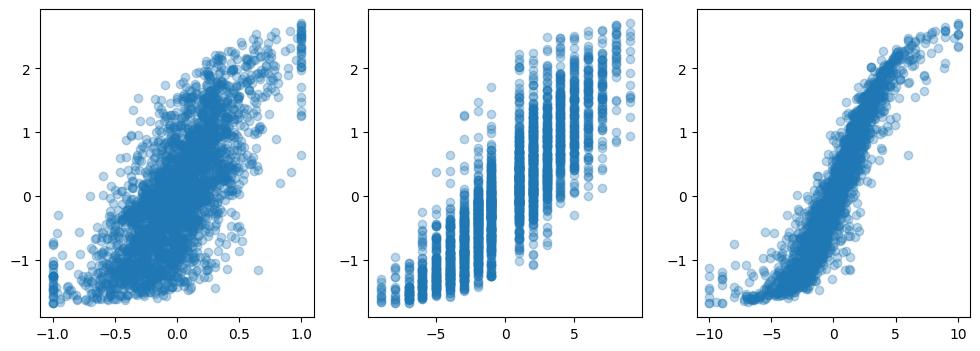

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

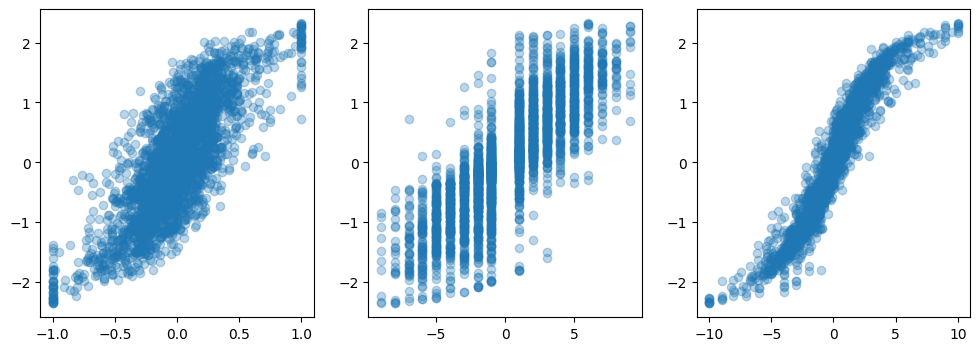

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


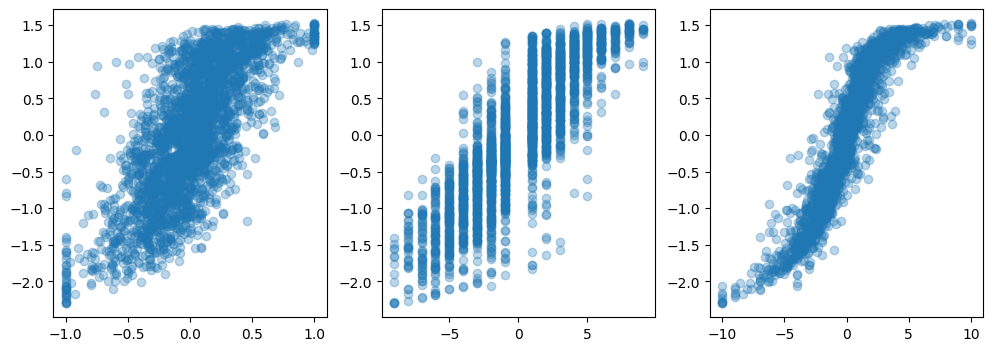

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);
